## Land Use Classification | CNN Model with Data Augmentation

This notebook explores training the same convolutional neural network architecture on a more robust dataset created using data augmentation of the original images.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model

from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage

%matplotlib inline

Using TensorFlow backend.


In [3]:
# set up reproducible environment
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed = 123
random.seed(456)
tf.set_random_seed(789)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [4]:
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims) //rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
gen = ImageDataGenerator(rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        zoom_range=0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

In [6]:
image_path = '/Users/limesncoconuts2/datasets/land-use-jpeg/train/River/River_1.jpeg'

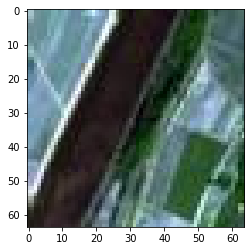

In [7]:
# Obtain image
image = np.expand_dims(ndimage.imread(image_path), 0)
plt.imshow(image[0])
plt.show()

In [8]:
# Generate batched of augmented images from this image
aug_iter = gen.flow(image) #takes numpy data and returns batches of augmented dat

In [9]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

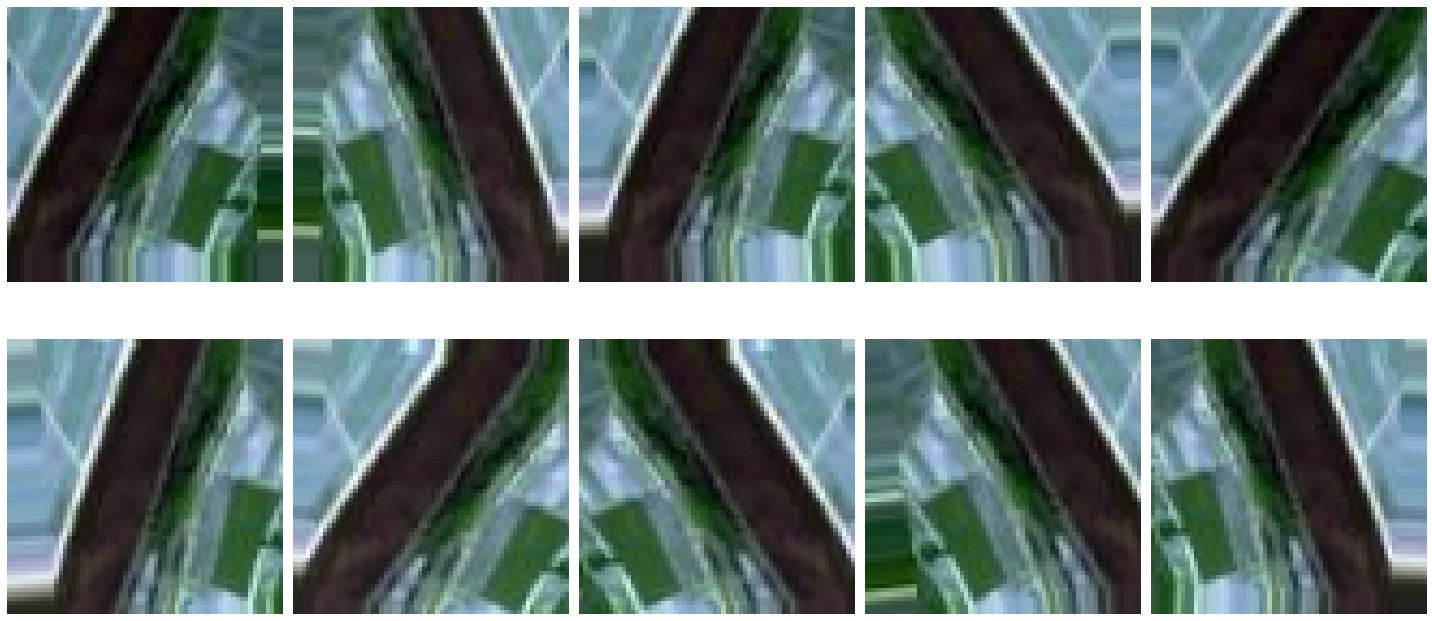

In [10]:
# Augmented images
plots(aug_images, figsize=(20, 10), rows=2)

## Train CNN on Augmented Data

### Data Preparation

In [11]:
base_path= '/Users/limesncoconuts2/datasets'
train_path = os.path.join(base_path, 'land-use-jpeg/train')
valid_path = os.path.join(base_path, 'land-use-jpeg/valid')
test_path = os.path.join(base_path, 'land-use-jpeg/test')

In [12]:
categories = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(base_path, 'land-use-tif')):
    categories.extend(dirnames)

In [13]:
# ImageDataGenerator for transformations
train_gen = ImageDataGenerator(rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        zoom_range=0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

In [14]:
train_batches = train_gen.flow_from_directory(train_path,
                                              target_size=(64, 64),
                                              classes=categories,
                                              batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)

Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [15]:
# plots images with labels within jupyter notebook
# from Github / YouTube user deeplizard: https://www.youtube.com/watch?v=LhEMXbjGV_4

def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims) //rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [16]:
imgs, labels = next(train_batches)

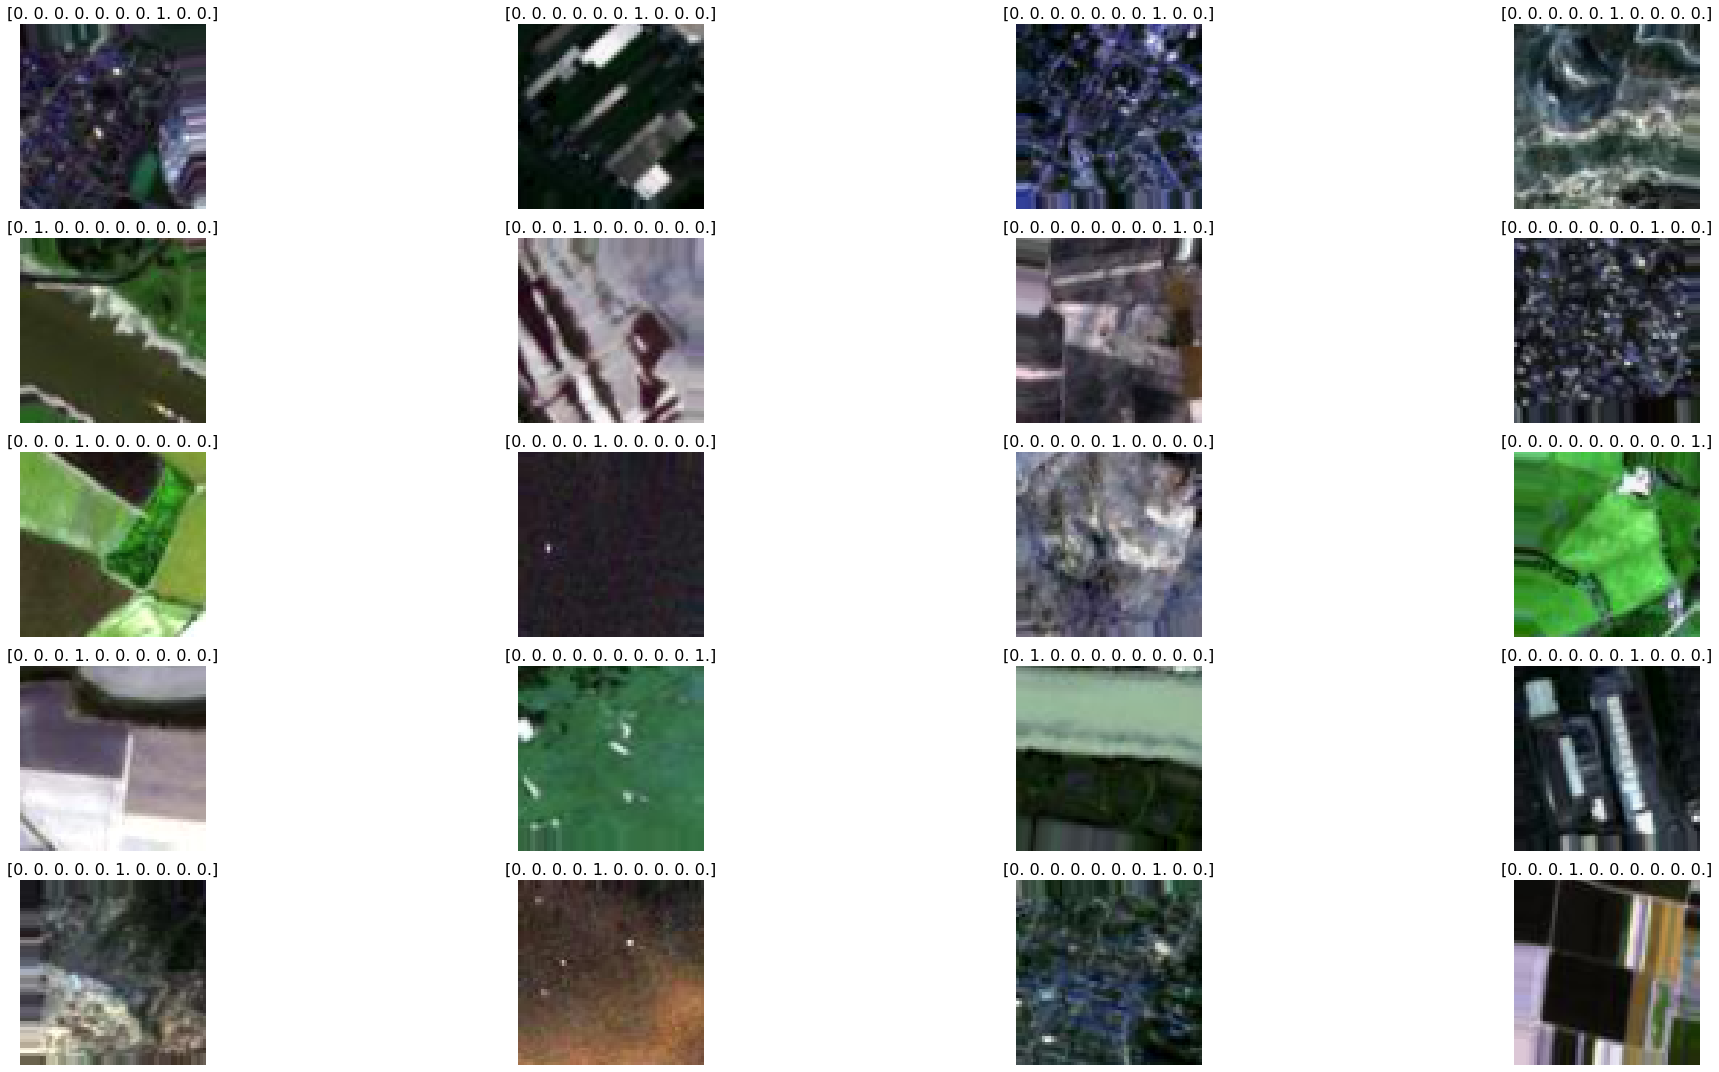

In [17]:
plots(imgs, rows=5, titles=labels)

###  Train CNN

In [20]:
model = load_model('land_use_model.h5')
model.summary()

ValueError: You are trying to load a weight file containing 16 layers into a model with 0 layers

In [19]:
NUM_TRAINABLE_LAYERS = 14
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

NameError: name 'model' is not defined

In [ ]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit_generator(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=10,
                   verbose=2)

### Predict

In [ ]:
test_labels = test_batches.classes
test_labels

In [ ]:
test_batches.class_indices

In [ ]:
predictions = model.predict_generator(test_batches, steps=270, verbose=0)

In [ ]:
# modified from scikit-learn.org by YouTube user deeplizard

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [ ]:
# save model
model.save('land_use_model_2.h5')

## Plots

Loss and accuracy of the model over the training and validation data during training.

[source](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# undo initializations
del model
K.clear_session() 
np.random.seed(12)    
rn.seed(123)    
tf.set_random_seed(1234)